# Johdanto Datatieteeseen 2021 -practical work
### *author: Ilpo Viertola*
During this work, I've used [this Jupyter-notebook](https://www.kaggle.com/lunamcbride24/covid19-tweet-truth-analysis) as reference.

In [190]:
# Normal stuff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# For Twitter API
import tweepy
import ast

# Tweet preprocessing
import nltk
nltk.download('stopwords')  # Download stopwords (not downloaded if up to date)
nltk.download('wordnet')    # Download wordnet for lemmatizer (not downloaded if up to date)
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import html
import string

# Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Describing the data
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import ngrams
from nltk import FreqDist

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ilpoviertola/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ilpoviertola/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Reading the data
**Read the data in from [Kaggle csv-files](https://www.kaggle.com/elvinagammed/covid19-fake-news-dataset-nlp) and with Twitter API.**

In [191]:
csv_path = '/Users/ilpoviertola/OneDrive - TUNI.fi/Kurssimateriaaleja/JODA/datasets/covid19_fake_news'
# Data to train the model with
train_df = pd.read_csv(csv_path + '/Constraint_Train.csv')
train_df.head()
# Data to test the model with
test_df = pd.read_csv(csv_path + '/Constraint_Test.csv')
test_df.head()
# Data to validate the model with
val_df = pd.read_csv(csv_path + '/Constraint_Val.csv')
val_df.head()

,id,tweet,label
0,1,Chinese converting to Islam after realising th...,fake
1,2,11 out of 13 people (from the Diamond Princess...,fake
2,3,"COVID-19 Is Caused By A Bacterium, Not Virus A...",fake
3,4,Mike Pence in RNC speech praises Donald Trump’...,fake
4,5,6/10 Sky's @EdConwaySky explains the latest #C...,real


**Next Twitter data. First lets authenticate ourselves so we can use Twitter API.**

In [192]:
# Fetch Twitter API-keys from a local file.
key_file = open('twitter.key', 'r')
keys = ast.literal_eval(key_file.read())
key_file.close()

auth = tweepy.OAuthHandler(keys['API'], keys['API_secret'])
auth.set_access_token(keys['Access_token'], keys['Access_token_secret'])
api = tweepy.API(auth)

**Create DataFrame where the tweets are stored and fetch tweets.**

In [193]:
# Create DataFrame for tweets
tweet_df = pd.DataFrame(columns=['username', 'description', 'location', 'following', 'followers', 'totaltweets', 'retweetcount', 'text', 'hashtags'])

# Get tweets
hashtag = '#covid19'
d_since = '2021-04-07'
limit = 250
tweets = tweepy.Cursor(api.search, q=hashtag, lang='en', since=d_since, tweet_mode='extended').items(limit)
tweets_list = [tweet for tweet in tweets]

**Process tweets and add them to DataFrame. We'll exclude retweets.**

In [194]:
for tweet in tweets_list:
    # Data about tweets
    username = tweet.user.screen_name
    description = tweet.user.description
    location = tweet.user.location
    following = tweet.user.friends_count
    followers = tweet.user.followers_count
    totaltweets = tweet.user.statuses_count
    retweetcount = tweet.retweet_count
    hashtags = tweet.entities['hashtags']
    
    # Let's ignore all retweets
    if not tweet.retweeted and ('RT @' not in tweet.full_text):

        text = tweet.full_text
        hashtext = list()
        for j in range(0, len(hashtags)):
            hashtext.append(hashtags[j]['text'])
            
        # Lisätään data DataFrameen.
        ith_tweet = [username, description, location, following, followers, totaltweets, 
                    retweetcount, text, hashtext]
        tweet_df.loc[len(tweet_df)] = ith_tweet

tweet_df.head()

,username,description,location,following,followers,totaltweets,retweetcount,text,hashtags
0,GabrielsChrista,Helping Businesses Grow Entrepreneur 🚀 Webtalk...,,5000,3320,19766,1,✨✨✨Webtalk Rewards Presentation ✨✨✨\n\nHow to ...,"[AffiliateMarketing, DigitalMarketing, Marketi..."
1,AllThingsTelang,#Telangana News for Use. No Hashtag Activism. ...,"Chevella, Ranga Reddy District",3,776,11441,0,BLACK MARKETING!!\n\nDon’t waste your money on...,"[Remdesivir, Vials, atazolizumab, Cipla, Heter..."
2,SeanLucan,"Evidence over ideology, reason over irrational...","Bronx, NY",751,1539,7894,0,"Like an ""A STUDENT,"" your #immune system doesn...","[immune, COVID19, adaptation, education, memor..."
3,BellLawFirm,Georgia’s leading law firm for victims of medi...,"Atlanta, Georgia",240,220,613,0,#PatientSafety: when can you go to the doctor’...,"[PatientSafety, COVID19]"
4,ScottBourquin,The guy that flies jets and has the Cool Toys.,"Huntington Beach, Ca",119,68,981,0,"I am confused, we need an ID tonget #COVID19 V...","[COVID19, makesnosense]"


## Data exploration
**Check column names**

In [195]:
print('Training & validation data\'s columns:')
print(train_df.columns.values)
print(val_df.columns.values)
print('Test data\'s columns:')
print(test_df.columns.values)
print('Twitter data\'s columns:')
print(tweet_df.columns.values)

Training & validation data's columns:
['id' 'tweet' 'label']
['id' 'tweet' 'label']
Test data's columns:
['id' 'tweet']
Twitter data's columns:
['username' 'description' 'location' 'following' 'followers' 'totaltweets'
 'retweetcount' 'text' 'hashtags']


**Columns are ok. Next check null-values and dataypes**

In [196]:
print('Null values in training data? ' + str(train_df.isnull().values.any()))
print('Null values in testing data? ' + str(test_df.isnull().values.any()))
print('Null values in validation data? ' + str(val_df.isnull().values.any()))
print('Null values in Twitter data? ' + str(tweet_df.isnull().values.any()))

Null values in training data? False
Null values in testing data? False
Null values in validation data? False
Null values in Twitter data? False


In [197]:
print('Datatypes for training data: \n' + str(train_df.dtypes) + '\n')
print('Datatypes for validation data: \n' + str(val_df.dtypes) + '\n')
print('Datatypes for testing data: \n' + str(test_df.dtypes) + '\n')
print('Datatypes for Twitter data: \n' + str(tweet_df.dtypes) + '\n')

Datatypes for training data: 
id        int64
tweet    object
label    object
dtype: object

Datatypes for validation data: 
id        int64
tweet    object
label    object
dtype: object

Datatypes for testing data: 
id        int64
tweet    object
dtype: object

Datatypes for Twitter data: 
username        object
description     object
location        object
following       object
followers       object
totaltweets     object
retweetcount    object
text            object
hashtags        object
dtype: object



**Twitter dataset needs some datatype modifications.**

In [198]:
tweet_df = tweet_df.astype({'following': 'int32', 'followers': 'int32', 
                            'totaltweets': 'int32', 'retweetcount': 'int32'})
print('New datatypes for Twitter data: \n' + str(tweet_df.dtypes) + '\n')

New datatypes for Twitter data: 
username        object
description     object
location        object
following        int32
followers        int32
totaltweets      int32
retweetcount     int32
text            object
hashtags        object
dtype: object



In [199]:
print('\nExample tweet from training data: ')
print(train_df['tweet'][5])
print('\nExample tweet from Twitter data: ')
print(tweet_df['text'][5])


Example tweet from training data: 
Covid Act Now found "on average each person in Illinois with COVID-19 is infecting 1.11 other people. Data shows that the infection growth rate has declined over time this factors in the stay-at-home order and other restrictions put in place." https://t.co/hhigDd24fE

Example tweet from Twitter data: 
With a view to contain to spread of COVID-19, Nua Sahi &amp; Brahmana Sahi of Haridapadar village under @BlockAska has been declared as a Mini Containment Zone. All inhabitants within the area shall strictly remain in home &amp; follow the #COVID19 protocols.
@Ganjam_Admin
@DRDAGanjam https://t.co/JySJWen6Jy


**Tweets typically contain links, other people's usernames, hashtags and emojis. These must be cleaned before training the model...**

In [200]:
print('Training data labels: \n', train_df['label'].value_counts())
print('\nValidation data labels: \n', val_df['label'].value_counts())

Training data labels: 
 real    3360
fake    3060
Name: label, dtype: int64

Validation data labels: 
 real    1120
fake    1020
Name: label, dtype: int64


**Datasets are balanced, meaning they contain approximately as much fake and real news. These values must be binarycoded in the future.**  
  
## Tweet preprocessing aka. feature extraction

In [201]:
puncs = string.punctuation
stopws = stopwords.words('english')
print(puncs)
print(stopws)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only

In [204]:
def tweet_cleaner(tweets):
    for i in range(0, len(tweets)):
        tweet = tweets[i]

        emoji_pattern = re.compile(pattern = '['
            u'\U0001F600-\U0001F64F'  # emoticons
            u'\U0001F300-\U0001F5FF'  # symbols & pictographs
            u'\U0001F680-\U0001F6FF'  # transport & map symbols
            u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
            u'\U00002702-\U000027B0'
            u'\U000024C2-\U0001F251'
            u'\U0001f926-\U0001f937'
            u'\U00010000-\U0010ffff'
            u'\u2640-\u2642'
            u'\u2600-\u2B55'
            u'\u200d'
            u'\u23cf'
            u'\u23e9'
            u'\u231a'
            u'\ufe0f'  # dingbats
            u'\u3030'
            ']+', flags = re.UNICODE)

        tweet = html.unescape(tweet)    # Remove leftover HTML elements
        tweet = re.sub(r'@\w+', ' ', tweet) # Remove mentions to other people
        tweet = re.sub(r'http\S+', ' ', tweet)  # Remove links
        tweet = emoji_pattern.sub(r'', tweet)   # Remove emojis
        tweet = re.sub('\d+', '', tweet)    # Remove numbers
        
        tweet = ''.join([punc for punc in tweet if not punc in puncs])   # Remove punctuation
        tweet = tweet.lower()   # Lowercase text
    
        tweetWord = tweet.split()   # Split to words

        lemmatiser = WordNetLemmatizer()
        tweetWord = [lemmatiser.lemmatize(word, pos='v') for word in tweetWord] # Lemmatize words

        tweets[i] = ''.join([word + ' ' for word in tweetWord if not word in stopws]) # Exclude stopwords
        
    return tweets 

In [205]:
train_df['clean_tweet'] = tweet_cleaner(train_df['tweet'].copy())
train_df.head()

,id,tweet,label,clean_tweet
0,1,The CDC currently reports 99031 deaths. In gen...,real,cdc currently report deaths general discrepanc...
1,2,States reported 1121 deaths a small rise from ...,real,state report deaths small rise last tuesday so...
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake,politically correct woman almost use pandemic ...
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real,indiafightscorona covid test laboratories indi...
4,5,Populous states can generate large case counts...,real,populous state generate large case count look ...


In [206]:
test_df['clean_tweet'] = tweet_cleaner(test_df['tweet'].copy())
test_df.head()

,id,tweet,clean_tweet
0,1,Our daily update is published. States reported...,daily update publish state report k test k new...
1,2,Alfalfa is the only cure for COVID-19.,alfalfa cure covid
2,3,President Trump Asked What He Would Do If He W...,president trump ask would catch coronavirus do...
3,4,States reported 630 deaths. We are still seein...,state report deaths still see solid national d...
4,5,This is the sixth time a global health emergen...,sixth time global health emergency declare int...


In [207]:
val_df['clean_tweet'] = tweet_cleaner(val_df['tweet'].copy())
val_df.head()

,id,tweet,label,clean_tweet
0,1,Chinese converting to Islam after realising th...,fake,chinese convert islam realise muslim affect co...
1,2,11 out of 13 people (from the Diamond Princess...,fake,people diamond princess cruise ship intially t...
2,3,"COVID-19 Is Caused By A Bacterium, Not Virus A...",fake,covid cause bacterium virus treat aspirin
3,4,Mike Pence in RNC speech praises Donald Trump’...,fake,mike pence rnc speech praise donald trump’s co...
4,5,6/10 Sky's @EdConwaySky explains the latest #C...,real,sky explain latest covid data government annou...


In [208]:
tweet_df['clean_tweet'] = tweet_cleaner(tweet_df['text'].copy())
tweet_df.head()

,username,description,location,following,followers,totaltweets,retweetcount,text,hashtags,clean_tweet
0,GabrielsChrista,Helping Businesses Grow Entrepreneur 🚀 Webtalk...,,5000,3320,19766,1,✨✨✨Webtalk Rewards Presentation ✨✨✨\n\nHow to ...,"[AffiliateMarketing, DigitalMarketing, Marketi...",webtalk reward presentation earn webtalk affil...
1,AllThingsTelang,#Telangana News for Use. No Hashtag Activism. ...,"Chevella, Ranga Reddy District",3,776,11441,0,BLACK MARKETING!!\n\nDon’t waste your money on...,"[Remdesivir, Vials, atazolizumab, Cipla, Heter...",black market don’t waste money remdesivir arti...
2,SeanLucan,"Evidence over ideology, reason over irrational...","Bronx, NY",751,1539,7894,0,"Like an ""A STUDENT,"" your #immune system doesn...","[immune, COVID19, adaptation, education, memor...",like student immune system doesnt memorize les...
3,BellLawFirm,Georgia’s leading law firm for victims of medi...,"Atlanta, Georgia",240,220,613,0,#PatientSafety: when can you go to the doctor’...,"[PatientSafety, COVID19]",patientsafety go doctor’s office fully vaccina...
4,ScottBourquin,The guy that flies jets and has the Cool Toys.,"Huntington Beach, Ca",119,68,981,0,"I am confused, we need an ID tonget #COVID19 V...","[COVID19, makesnosense]",confuse need id tonget covid vaccine vote make...


**Remove rows that have blank clean_tweets. (This could be the case if the tweet only contained e.g. a link)**

In [209]:
train_df['clean_tweet'].replace('', np.nan, inplace=True)
test_df['clean_tweet'].replace('', np.nan, inplace=True)
val_df['clean_tweet'].replace('', np.nan, inplace=True)
tweet_df['clean_tweet'].replace('', np.nan, inplace=True)

train_df.dropna(subset=['clean_tweet'], inplace=True)
test_df.dropna(subset=['clean_tweet'], inplace=True)
val_df.dropna(subset=['clean_tweet'], inplace=True)
tweet_df.dropna(subset=['clean_tweet'], inplace=True)

**Compare "dirty" and "clean" tweet**

In [210]:
print('Some dirty tweet:\n', train_df['tweet'][150])
print('\nClean version:\n', train_df['clean_tweet'][150])

Some dirty tweet:
 Thirty-nine GPs and specialists have written to the BMJ calling for action on long COVID. https://t.co/4Y5kGv3pF3 https://t.co/jTc1OucOmw

Clean version:
 thirtynine gps specialists write bmj call action long covid 


**Binarycode label-colum values to is_real-column in train_df and val_df. 0 = fake, 1 = real**

In [211]:
train_df['is_real'] = pd.get_dummies(train_df['label'])['real']
val_df['is_real'] = pd.get_dummies(val_df['label'])['real']
val_df.head()

,id,tweet,label,clean_tweet,is_real
0,1,Chinese converting to Islam after realising th...,fake,chinese convert islam realise muslim affect co...,0
1,2,11 out of 13 people (from the Diamond Princess...,fake,people diamond princess cruise ship intially t...,0
2,3,"COVID-19 Is Caused By A Bacterium, Not Virus A...",fake,covid cause bacterium virus treat aspirin,0
3,4,Mike Pence in RNC speech praises Donald Trump’...,fake,mike pence rnc speech praise donald trump’s co...,0
4,5,6/10 Sky's @EdConwaySky explains the latest #C...,real,sky explain latest covid data government annou...,1


**Export dataframes to csv-files**

In [212]:
if not os.path.exists(csv_path + '/modified_datasets'):
    os.makedirs(csv_path + '/modified_datasets')

train_df.to_csv(csv_path + '/modified_datasets/train.csv')
test_df.to_csv(csv_path + '/modified_datasets/test.csv')
val_df.to_csv(csv_path + '/modified_datasets/val.csv')
tweet_df.to_csv(csv_path + '/modified_datasets/tweets.csv')

### Tokenization and padding

In [213]:
train_clean = train_df['clean_tweet'].copy()
test_clean = test_df['clean_tweet'].copy()
val_clean = val_df['clean_tweet'].copy()
tweet_clean = tweet_df['clean_tweet'].copy()

all_clean = train_clean.append(val_clean, ignore_index=True).append(test_clean, ignore_index=True).append(tweet_clean, ignore_index=True)
print('Amount of tweets:', len(all_clean))

Amount of tweets: 10749


In [214]:
# This Tokenizer contains an integer value for every individual word that is in all_clean dataset.
# This is done because neural networks do not operate on words, so
# we need to map a word to a integer.
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_clean)

In [215]:
# This function returns a list of integers. Each integer is mapped to a certain word.
# This list is the clean_tweet coded to integer values.
# Every sequence aka. list must be same length so we need to also pad shorter sequences with 0s.
def tokenize_tweet(tweets):
    texts = tokenizer.texts_to_sequences(tweets) # Convert clean_tweet to sequence of integers.
    texts = pad_sequences(texts, padding='post') # Pad the sequences with 0s so lenghts match.
    return texts

In [216]:
texts_train = tokenize_tweet(train_df["clean_tweet"].copy()) # Collect the tweet sequences
train_df["tweet_sequence"] = list(texts_train)
train_df.head()

,id,tweet,label,clean_tweet,is_real,tweet_sequence
0,1,The CDC currently reports 99031 deaths. In gen...,real,cdc currently report deaths general discrepanc...,1,"[91, 200, 6, 10, 632, 4113, 87, 386, 387, 412,..."
1,2,States reported 1121 deaths a small rise from ...,real,state report deaths small rise last tuesday so...,1,"[7, 6, 10, 656, 130, 45, 1010, 2326, 7, 6, 10,..."
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake,politically correct woman almost use pandemic ...,0,"[5106, 1117, 393, 459, 37, 23, 2327, 3505, 177..."
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real,indiafightscorona covid test laboratories indi...,1,"[18, 1, 3, 212, 15, 122, 215, 3, 1414, 101, 12..."
4,5,Populous states can generate large case counts...,real,populous state generate large case count look ...,1,"[5107, 7, 1999, 429, 2, 386, 197, 5, 2, 100, 5..."


In [217]:
texts_test = tokenize_tweet(test_df["clean_tweet"].copy())
test_df["tweet_sequence"] = list(texts_test)
test_df.head()

,id,tweet,clean_tweet,tweet_sequence
0,1,Our daily update is published. States reported...,daily update publish state report k test k new...,"[41, 17, 92, 7, 6, 35, 3, 35, 5, 2, 10, 241, 2..."
1,2,Alfalfa is the only cure for COVID-19.,alfalfa cure covid,"[12579, 76, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
2,3,President Trump Asked What He Would Do If He W...,president trump ask would catch coronavirus do...,"[83, 42, 324, 160, 611, 4, 303, 4, 0, 0, 0, 0,..."
3,4,States reported 630 deaths. We are still seein...,state report deaths still see solid national d...,"[7, 6, 10, 117, 27, 2016, 144, 422, 87, 6, 809..."
4,5,This is the sixth time a global health emergen...,sixth time global health emergency declare int...,"[2728, 33, 332, 14, 384, 870, 532, 14, 2421, 1..."


In [218]:
texts_val = tokenize_tweet(val_df["clean_tweet"].copy())
val_df["tweet_sequence"] = list(texts_val)
val_df.head()

,id,tweet,label,clean_tweet,is_real,tweet_sequence
0,1,Chinese converting to Islam after realising th...,fake,chinese convert islam realise muslim affect co...,0,"[188, 1733, 2477, 2884, 689, 292, 4, 5813, 89,..."
1,2,11 out of 13 people (from the Diamond Princess...,fake,people diamond princess cruise ship intially t...,0,"[8, 3614, 3207, 1280, 801, 11247, 3, 196, 3, 1..."
2,3,"COVID-19 Is Caused By A Bacterium, Not Virus A...",fake,covid cause bacterium virus treat aspirin,0,"[1, 120, 2234, 24, 183, 2213, 0, 0, 0, 0, 0, 0..."
3,4,Mike Pence in RNC speech praises Donald Trump’...,fake,mike pence rnc speech praise donald trump’s co...,0,"[1805, 1645, 2631, 2630, 1820, 199, 1310, 1, 4..."
4,5,6/10 Sky's @EdConwaySky explains the latest #C...,real,sky explain latest covid data government annou...,1,"[740, 493, 105, 1, 32, 75, 2120, 28, 4, 32, 0,..."


In [219]:
texts_tweets = tokenize_tweet(tweet_df["clean_tweet"].copy())
tweet_df["tweet_sequence"] = list(texts_tweets)
tweet_df.head()

,username,description,location,following,followers,totaltweets,retweetcount,text,hashtags,clean_tweet,tweet_sequence
0,GabrielsChrista,Helping Businesses Grow Entrepreneur 🚀 Webtalk...,,5000,3320,19766,1,✨✨✨Webtalk Rewards Presentation ✨✨✨\n\nHow to ...,"[AffiliateMarketing, DigitalMarketing, Marketi...",webtalk reward presentation earn webtalk affil...,"[7048, 5078, 4107, 2419, 7048, 14019, 14020, 1..."
1,AllThingsTelang,#Telangana News for Use. No Hashtag Activism. ...,"Chevella, Ranga Reddy District",3,776,11441,0,BLACK MARKETING!!\n\nDon’t waste your money on...,"[Remdesivir, Vials, atazolizumab, Cipla, Heter...",black market don’t waste money remdesivir arti...,"[499, 704, 510, 2427, 594, 1819, 2535, 1450, 1..."
2,SeanLucan,"Evidence over ideology, reason over irrational...","Bronx, NY",751,1539,7894,0,"Like an ""A STUDENT,"" your #immune system doesn...","[immune, COVID19, adaptation, education, memor...",like student immune system doesnt memorize les...,"[118, 1546, 659, 313, 535, 14033, 4073, 1085, ..."
3,BellLawFirm,Georgia’s leading law firm for victims of medi...,"Atlanta, Georgia",240,220,613,0,#PatientSafety: when can you go to the doctor’...,"[PatientSafety, COVID19]",patientsafety go doctor’s office fully vaccina...,"[14035, 56, 3265, 1127, 1466, 945, 1, 0, 0, 0,..."
4,ScottBourquin,The guy that flies jets and has the Cool Toys.,"Huntington Beach, Ca",119,68,981,0,"I am confused, we need an ID tonget #COVID19 V...","[COVID19, makesnosense]",confuse need id tonget covid vaccine vote make...,"[1916, 98, 2149, 14036, 1, 25, 924, 14037, 0, ..."


In [221]:
print('Some clean tweet:', train_df['clean_tweet'][300])
print('\nSame tweet\'s encoded sequence (0-20):', train_df['tweet_sequence'][300][0:20])
print('\nSequence transformed back to normal text:', tokenizer.sequences_to_texts([train_df['tweet_sequence'][300]]))

Some clean tweet: new numerous covid outbreaks recent cruise ship voyage extend previous sail order prevent spread covid among crew onboard 

Same tweet's encoded sequence (0-20): [   5 5220    1  628  365 1280  801 7245  869  736 4220  272  137   31
    1  363 2378 5221    0    0]

Sequence transformed back to normal text: ['new numerous covid outbreaks recent cruise ship voyage extend previous sail order prevent spread covid among crew onboard']


## Describing the data
In this section, we will take a look inside the datasets we're going to use in this work.

In [222]:
print('The total number of words: ', len(tokenizer.word_index) + 1)
word_amnts = pd.DataFrame(columns=['word', 'amount'])
for i, (word, count) in enumerate(tokenizer.word_counts.items()):
    word_amnts.loc[i] = [word, count]
word_amnts = word_amnts.astype({'amount':'int32'})
word_amnts = word_amnts.sort_values(by='amount', axis=0, ascending=False)

The total number of words:  14115


**Plot of 15 most common words and their occurence amounts**

([<matplotlib.axis.XTick at 0x7fadc4014210>,
 [Text(0, 0, 'covid'),
  Text(1, 0, 'case'),
  Text(2, 0, 'test'),
  Text(3, 0, 'coronavirus'),
  Text(4, 0, 'new'),
  Text(5, 0, 'report'),
  Text(6, 0, 'state'),
  Text(7, 0, 'people'),
  Text(8, 0, 'number'),
  Text(9, 0, 'deaths'),
  Text(10, 0, 'total'),
  Text(11, 0, 'say'),
  Text(12, 0, 'confirm'),
  Text(13, 0, 'health'),
  Text(14, 0, 'india')])

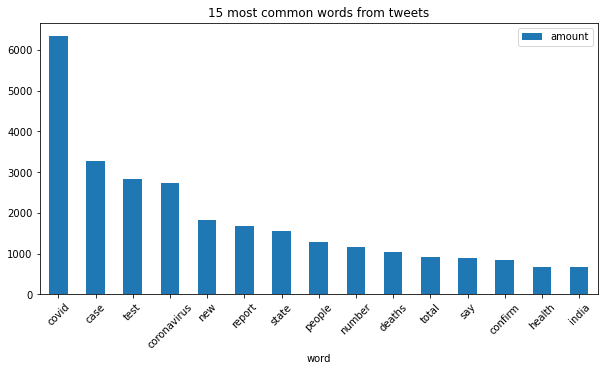

In [227]:
amnt_plot = word_amnts[:15].plot.bar(x='word', y='amount', figsize=(10,5), title='15 most common words from tweets')
plt.xticks(ticks=np.arange(15), labels=word_amnts['word'][:15], rotation=45)

**TF-IDFs for dataset**

([<matplotlib.axis.XTick at 0x7fadc42178d0>,
 [Text(0, 0, 'death'),
  Text(1, 0, 'explicable'),
  Text(2, 0, 'discrepancies'),
  Text(3, 0, 'roughly'),
  Text(4, 0, 'small'),
  Text(5, 0, 'general'),
  Text(6, 0, 'toll'),
  Text(7, 0, 'different'),
  Text(8, 0, 'count'),
  Text(9, 0, 'source')])

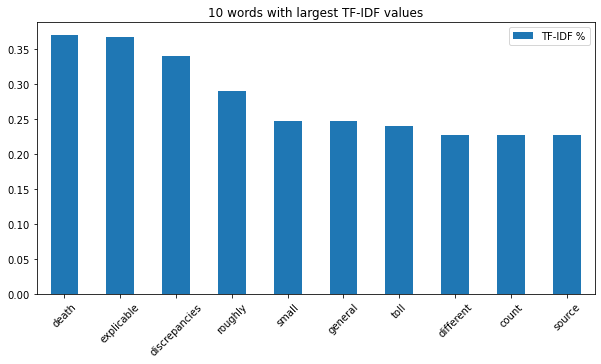

In [228]:
tfIdfVectorizer=TfidfVectorizer(use_idf=True)
tfIdf = tfIdfVectorizer.fit_transform(all_clean)
tfIdf_df = pd.DataFrame(tfIdf[0].T.todense(), index=tfIdfVectorizer.get_feature_names(), columns=['TF-IDF %'])
tfIdf_df['word'] = tfIdfVectorizer.get_feature_names()
tfIdf_df = tfIdf_df.sort_values('TF-IDF %', ascending=False)
tfIdf_df[:10].plot.bar(figsize=(10,5), title='10 words with largest TF-IDF values')
plt.xticks(ticks=np.arange(10), labels=tfIdf_df['word'][:10], rotation=45)

**Tweets' lenghts in words**

Text(0.5, 0, 'Word count in tweet')

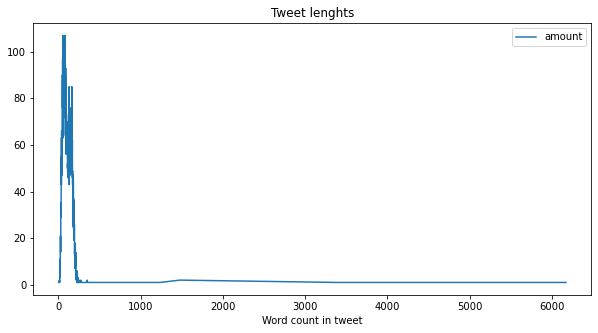

In [225]:
tweet_lens = {}

for tweet in all_clean:
    length = len(tweet)
    if length in tweet_lens.keys():
        tweet_lens[length] += 1
    else:
        tweet_lens[length] = 1

tweet_lens_df = pd.DataFrame.from_dict(tweet_lens, orient='index', columns=['amount'])
tweet_lens_df = tweet_lens_df.sort_index()
tweet_lens_df.plot(figsize=(10,5), title='Tweet lenghts')
plt.xlabel('Word count in tweet')

Text(0.5, 0, 'Word count in tweet')

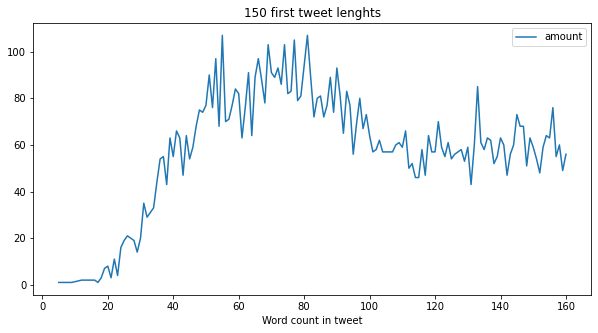

In [230]:
tweet_lens_df[:150].plot(figsize=(10,5), title='150 first tweet lenghts')
plt.xlabel('Word count in tweet')

**Insight to bigrams, a bigram consists out of two words that occur succesively in the text**

Text(0.5, 0, 'Bigrams')

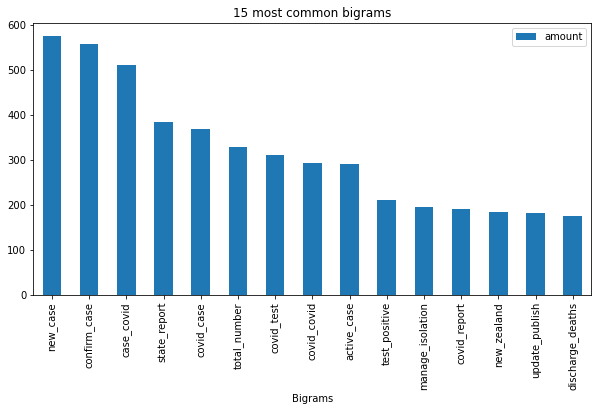

In [229]:
bigrams_all = {}
bigrams_freq = []

for tweet in all_clean:
    bgs = ngrams(tweet.split(), 2)

    for bg in bgs:
        bigrams_freq.append(bg)
        bg = str(bg[0]) + "_" + str(bg[1])
        if bg not in bigrams_all.keys():
            bigrams_all[bg] = 1
        else:
            bigrams_all[bg] += 1

bigrams_all_df = pd.DataFrame.from_dict(bigrams_all, orient='index', columns=['amount'])
bigrams_all_df = bigrams_all_df.astype({'amount':'int32'})
bigrams_all_df['bigrams'] = bigrams_all_df.index
bigrams_all_df = bigrams_all_df.sort_values(by='amount', axis=0, ascending=False)
bigrams_all_df[:15].plot.bar(figsize=(10,5), title='15 most common bigrams')
plt.xticks(ticks=np.arange(15), labels=bigrams_all_df['bigrams'][:15], rotation=90)
plt.xlabel('Bigrams')